# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Standard Section 6: PCA and Logistic Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Abhimanyu (Abhi) Vasishth, Robbert (Rob) Struyven<br/>

<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

For this section, our goal is to get you familiarized with Dimensionality Reduction using Principal Components Analysis (PCA) and to recap Logistic Regression from the last homework. This [medium article](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) was referenced extensively while creating this notebook.

Specifically, we will:

- Understand how to define the terms **big data** and **high-dimensionality** and see the motivation for PCA
- Learn what PCA is
- Use PCA in order to **visualize** a high-dimensional problem in 2-dimensions
- Learn about the sklearn PCA library and [its nuances](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- Get familiar with the Linear Algebra of PCA
- Meet the MNIST handwritten digit dataset (and hopefully stay friends for a while)
- Use PCA in order to **improve model training time** and understand the **speed-accuracy trade-off**
- Discuss when to use PCA and when not to use it

---

<img src="../fig/meme.png" width="400">

---

In [2]:
# Data and stats packages
import numpy as np
import pandas as pd

# Visualization packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Other packages
pd.set_option('display.max_columns', 50)
import warnings
warnings.filterwarnings("ignore")

# Motivation

Principal Components Analysis helps us deal with high-dimensionality in big-data. 

But first...

<img src="../fig/bigdata.png" width="600">

**High-dimensionality** is the case when p is large i.e. there are a lot of predictors. This is sometimes a problem because:

1. Our models may be overfit
2. There may be multi-collinearity
3. Matrices may not be invertible (in the case of OLS)

**Our challenge**: is to represent these p dimensions by a smaller number (m) dimensions without losing too much information. Then, we can fit a model using these m predictors, which addresses the three problems listed above. Here's where **PCA** comes into play.

# What is Principal Components Analysis (PCA)?

## A Framework For Dimensionality Reduction

We said that one way to reduce the dimensions of the feature space is to create a new, smaller set of predictors by taking **linear combinations** of the original predictors. Our original model (let's say it is a Linear Regression Model) looks like this:

$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p + \epsilon
$$

We choose $Z_1$, $Z_2$,$\dots$, $Z_m$, where $m < p$ and where each $Z_i$ is a linear combination of
the original p predictors, $X_1$ to $X_p$. We can say that:

$$
Z_i = \sum_{j=1}^{p} c_{ij} X_i
$$

for fixed constants $c_{ij}$  (PCA can determines them).  As an example, we could say that: 

$$
Z_1 = 3.3 X_1 + 4 X_2 + 0 X_3 + \dots + 1.2 X_p
$$

In the above equation, we see that $Z_1$ is a linear combination of the original predictors. Then we can build a linear regression model using the new predictors as follows:

$$
Y = \theta_0 + \theta_1 Z_1 + \theta_2 Z_2 + \dots + \theta_m Z_m + \epsilon
$$

Notice that this model has a smaller number (m+1 < p+1) of parameters. Each $Z_i$ is called **PRINCIPAL COMPONENT**. The principcal components consist an $m$-dimensional **orthonormal** system of coordinates.

PCA is a method to identify a new set of predictors, as linear combinations of the original ones, that captures the 'maximum amount' of variance  in the observed data. This is the basic assumption in the PCA.

<img src="../fig/pca.png" width="400">

We see that the "best line" is the one where there is maximal variance along the line. Source [here](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579).

<img src="../fig/pca.gif" width="1000">

In principle, we could explore all the rotations, that is, rotating our coordinate system under all the angles, and find which rotation yields the maximum variance or the smallest covariance. However, when the dimensionality (p) is large this is very time consuming and inefficient technique. In that case we may use PCA which is systematic way to find the best rotation or the best coordinate system. 
PCA is a mathematical method based on linear algebra, for more details and rigorous formulation see the notes in the advanced section for PCA.


## Applications of PCA

One major application of PCA is to address the issues we pointed out earlier (reduce the number of predictors).

In addition, another major application of PCA is in **visualization**. Specifically, if we have an N-dimensional dataset, how do we visualize it? 

**One option**: 

<img src="../fig/matrix.png" width="400">

**A more practical option**: use PCA to get the top 2-3 principal components and plot these components on 2-d or 3-d plots!

# PCA for Visualization

Data Source: [MTCars Dataset](https://gist.github.com/seankross/a412dfbd88b3db70b74b)

Here are a few resources that use this dataset and apply PCA for visualization. This notebook references [this PCA tutorial in R](https://www.datacamp.com/community/tutorials/pca-analysis-r), [these lecture notes from CMU](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf), this [blog](https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/), and [this blog](http://setosa.io/ev/principal-component-analysis/) which has some nice visualizations of PCA. 

### Loading in The Cars Dataset and carry out EDA

This dataset consists of data on 32 models of car, taken from an American motoring magazine (1974 Motor Trend magazine). For each car, you have 11 features, expressed in varying units (US units), They are as follows ([source](https://www.datacamp.com/community/tutorials/pca-analysis-r)):

- `mpg`: Fuel consumption (Miles per (US) gallon): more powerful and heavier cars tend to consume more fuel.
- `cyl`: Number of cylinders: more powerful cars often have more cylinders
- `disp`: Displacement (cu.in.): the combined volume of the engine's cylinders
- `hp`: Gross horsepower: this is a measure of the power generated by the car
- `drat`: Rear axle ratio: this describes how a turn of the drive shaft corresponds to a turn of the wheels. Higher values will decrease fuel efficiency.
- `wt`: Weight (1000 lbs): pretty self-explanatory!
- `qsec`: 1/4 mile time: the cars speed and acceleration
- `vs`: Engine block: this denotes whether the vehicle's engine is shaped like a "V", or is a more common straight shape.
- `am`: Transmission: this denotes whether the car's transmission is automatic (0) or manual (1).
- `gear`: Number of forward gears: sports cars tend to have more gears.
- `carb`: Number of carburetors: associated with more powerful engines

Note that the units used vary and occupy different scales. 

**We are dropping the categorical variables `vs` and `am` before we progress any further, and only keeping in the continuous predictors**.

In [3]:
cars_df = pd.read_csv('../data/mtcars.csv')
cars_df = cars_df[cars_df.columns.difference(['am', 'vs'])]
cars_df.head()

,carb,cyl,disp,drat,gear,hp,model,mpg,qsec,wt
0,4,6,160.0,3.90,4,110,Mazda RX4,21.0,16.46,2.620
1,4,6,160.0,3.90,4,110,Mazda RX4 Wag,21.0,17.02,2.875
2,1,4,108.0,3.85,4,93,Datsun 710,22.8,18.61,2.320
3,1,6,258.0,3.08,3,110,Hornet 4 Drive,21.4,19.44,3.215
4,2,8,360.0,3.15,3,175,Hornet Sportabout,18.7,17.02,3.440


In [4]:
cars_df.describe()

,carb,cyl,disp,drat,gear,hp,mpg,qsec,wt
count,32.0000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,2.8125,6.187500,230.721875,3.596563,3.687500,146.687500,20.090625,17.848750,3.217250
std,1.6152,1.785922,123.938694,0.534679,0.737804,68.562868,6.026948,1.786943,0.978457
min,1.0000,4.000000,71.100000,2.760000,3.000000,52.000000,10.400000,14.500000,1.513000
25%,2.0000,4.000000,120.825000,3.080000,3.000000,96.500000,15.425000,16.892500,2.581250
50%,2.0000,6.000000,196.300000,3.695000,4.000000,123.000000,19.200000,17.710000,3.325000
75%,4.0000,8.000000,326.000000,3.920000,4.000000,180.000000,22.800000,18.900000,3.610000
max,8.0000,8.000000,472.000000,4.930000,5.000000,335.000000,33.900000,22.900000,5.424000


**Our task** is to try to visualize this data in a meaningful way. Obviously we can't make a 9-dimensional plot, but we can try to make several different plots using the `pairplot` function from seaborn.

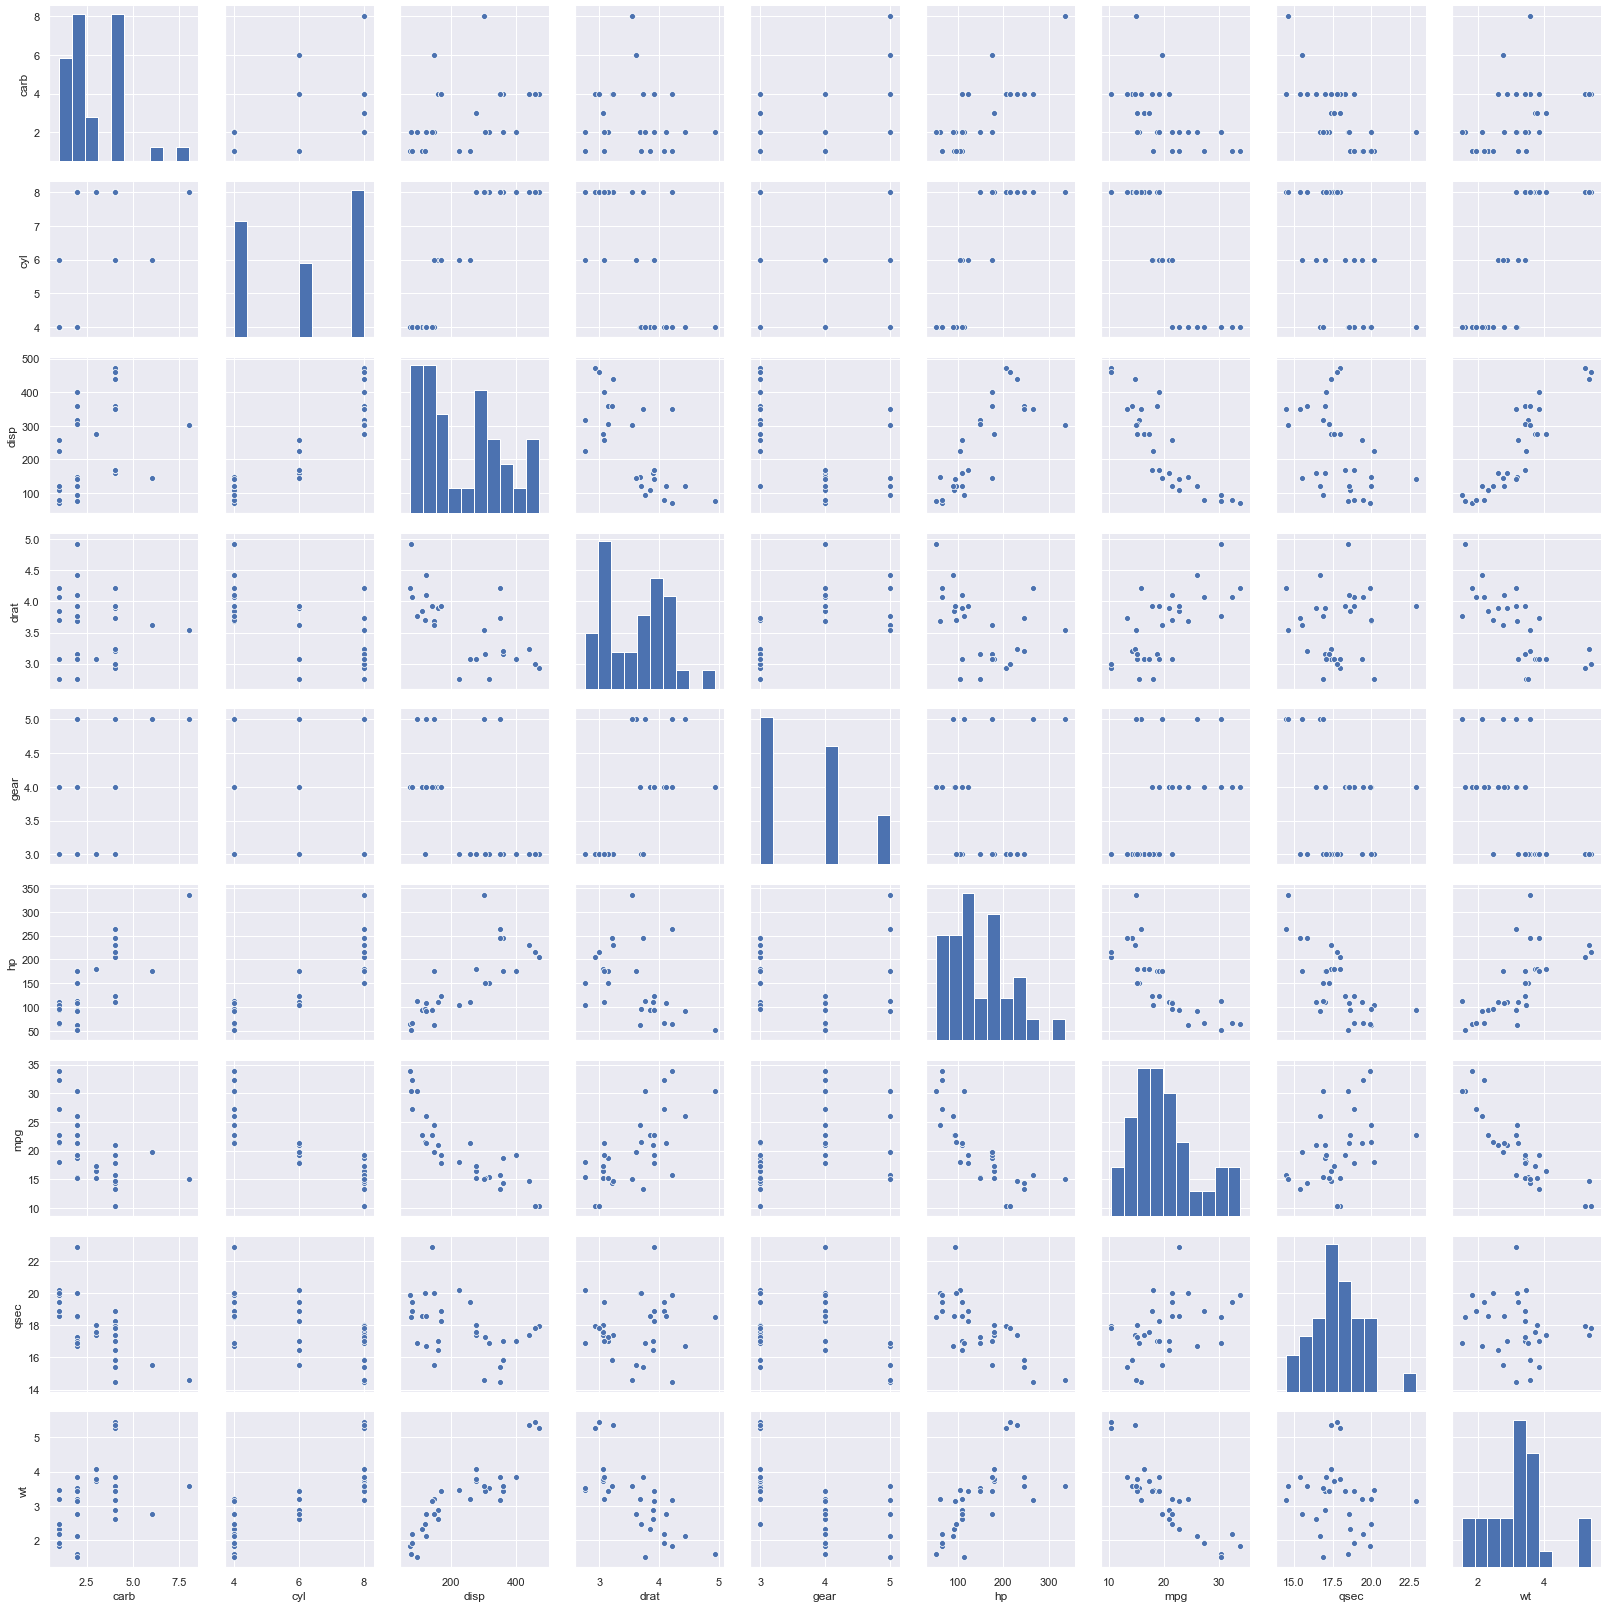

In [5]:
sns.pairplot(cars_df);

But there are numerous variables and numerous more relationships between these variables. We can do better through PCA.

## A Better Visualization using PCA

### Standardizing Variables
Standardization is crucial for PCA. For more details check the notes from the advanced section.

In [7]:
from sklearn.preprocessing import StandardScaler

# separating the quantitative predictors from the model of the car (a string)
model = cars_df['model']
quant_df = cars_df[cars_df.columns.difference(['model'])]

# Standardization
quant_scaled = StandardScaler().fit_transform(quant_df)
cars_df_scaled = pd.DataFrame(quant_scaled, columns=quant_df.columns)

# bringing back the model name
cars_df_scaled['model'] = cars_df['model']
cars_df_scaled.describe()
cars_df_scaled.head()

,carb,cyl,disp,drat,gear,hp,mpg,qsec,wt,model
0,0.746967,-0.106668,-0.579750,0.576594,0.430331,-0.543655,0.153299,-0.789601,-0.620167,Mazda RX4
1,0.746967,-0.106668,-0.579750,0.576594,0.430331,-0.543655,0.153299,-0.471202,-0.355382,Mazda RX4 Wag
2,-1.140108,-1.244457,-1.006026,0.481584,0.430331,-0.795570,0.456737,0.432823,-0.931678,Datsun 710
3,-1.140108,-0.106668,0.223615,-0.981576,-0.946729,-0.543655,0.220730,0.904736,-0.002336,Hornet 4 Drive
4,-0.511083,1.031121,1.059772,-0.848562,-0.946729,0.419550,-0.234427,-0.471202,0.231297,Hornet Sportabout


### Carrying out PCA

[Sklearn PCA documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [8]:
from sklearn.decomposition import PCA

# drop again the model predictor
quant_df = cars_df_scaled[cars_df_scaled.columns.difference(['model'])]

# fitting the PCA object onto our dataframe (excluding the model name column)
pca = PCA().fit(quant_df)

# transforming the dataframe
quant_df_pca = pca.transform(quant_df)

print(quant_df.shape)
print(quant_df_pca.shape)

(32, 9)
(32, 9)


Let us examine some of the attributes we obtain from PCA.

1. `explained_variance_`: The amount of variance explained by each of the selected principal components.
2. `explained_variance_ratio_`: Percentage of variance explained by each of the selected principal components. By default, if `n_components` is not set then all components are stored and the sum of the ratios is equal to 1.0.

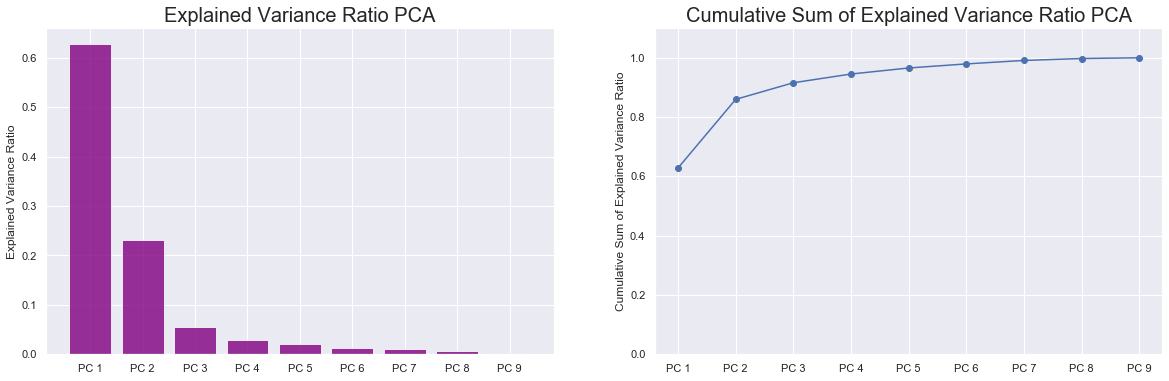

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.bar(range(len(ratio)), ratio, color='purple', alpha=0.8)
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_xticks(range(len(ratio)))
ax1.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax1.set_ylabel('Explained Variance Ratio')

# ratio[0]=0
ratio = pca.explained_variance_ratio_
# cumulative sum
ax2.plot(np.cumsum(ratio), 'o-')

ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)

ax2.set_ylim(0,1.1)
ax2.set_xticks(range(len(ratio)))
ax2.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

We see that over 85% of the variance is explained by the first 2 principal components! 

In [10]:
ratio

array([0.62843772, 0.23134448, 0.05602387, 0.0294475 , 0.02035096,
       0.0137548 , 0.01167355, 0.00650153, 0.0024656 ])

3. `components_`: This represents the principal components i.e. directions of maximum variance in the data. The components are sorted by `explained_variance_`. 

Let us write the equation for all the principal components using our formulation of the principal components above:

$$
Z_i = \sum_{j=1}^{p} w_{ij} X_i
$$

In [12]:
pca.components_

array([[-0.24458069, -0.40255368, -0.39735281,  0.3118165 ,  0.20947486,
        -0.36708145,  0.39314767,  0.22435083, -0.3734771 ],
       [ 0.4843131 ,  0.01570975, -0.08888469,  0.34165268,  0.55078264,
         0.26941371,  0.02753861, -0.48404435, -0.17194306],
       [ 0.46412069, -0.25231615, -0.07825139,  0.14995507,  0.20658376,
        -0.01721159, -0.22119309,  0.62812782,  0.45373418],
       [-0.21449222,  0.04070025,  0.33949373,  0.84565849, -0.28238183,
         0.06830099, -0.00612638, -0.03032913,  0.19126003],
       [-0.39978201, -0.11713968,  0.48678489, -0.16192593,  0.56248604,
         0.29473173,  0.320762  ,  0.14824951,  0.18748223],
       [ 0.35706914,  0.2243255 , -0.01967516, -0.01536794, -0.32298239,
         0.35394225,  0.72015586,  0.2575294 , -0.08377237],
       [-0.2060421 , -0.15893251, -0.18233095,  0.04767957, -0.08555707,
         0.69620751, -0.38138068,  0.27622581, -0.42777608],
       [-0.10832772,  0.81032177, -0.06416707,  0.13505066,  0

In [11]:
for i, comp in enumerate(pca.components_):
    expression = 'Z_{} = '.format(i+1)
    for c, x in zip(comp, quant_df.columns):
        if c < 0:
            expression += str(np.round(c,2)) + '*' + x + ' '
        else:
            expression += '+' + str(np.round(c,2)) + '*' + x + ' '
    print(expression + '\n')

Z_1 = -0.24*carb -0.4*cyl -0.4*disp +0.31*drat +0.21*gear -0.37*hp +0.39*mpg +0.22*qsec -0.37*wt 

Z_2 = +0.48*carb +0.02*cyl -0.09*disp +0.34*drat +0.55*gear +0.27*hp +0.03*mpg -0.48*qsec -0.17*wt 

Z_3 = +0.46*carb -0.25*cyl -0.08*disp +0.15*drat +0.21*gear -0.02*hp -0.22*mpg +0.63*qsec +0.45*wt 

Z_4 = -0.21*carb +0.04*cyl +0.34*disp +0.85*drat -0.28*gear +0.07*hp -0.01*mpg -0.03*qsec +0.19*wt 

Z_5 = -0.4*carb -0.12*cyl +0.49*disp -0.16*drat +0.56*gear +0.29*hp +0.32*mpg +0.15*qsec +0.19*wt 

Z_6 = +0.36*carb +0.22*cyl -0.02*disp -0.02*drat -0.32*gear +0.35*hp +0.72*mpg +0.26*qsec -0.08*wt 

Z_7 = -0.21*carb -0.16*cyl -0.18*disp +0.05*drat -0.09*gear +0.7*hp -0.38*mpg +0.28*qsec -0.43*wt 

Z_8 = -0.11*carb +0.81*cyl -0.06*disp +0.14*drat +0.32*gear -0.17*hp -0.12*mpg +0.36*qsec -0.2*wt 

Z_9 = -0.32*carb +0.16*cyl -0.66*disp +0.04*drat +0.05*gear +0.25*hp +0.11*mpg -0.17*qsec +0.57*wt 



Using the printed equations above, we can create vectors showing where each feature has a high value. Let us do this for the first 2 principal components (using $v$ to denote a vector): 

$$
\begin{aligned}
v_{carb} = \begin{pmatrix}-0.24 \\ 0.48 \end{pmatrix}, \;
v_{cyl} = \begin{pmatrix}-0.4 \\ 0.02 \end{pmatrix}, \; 
v_{disp} = \begin{pmatrix}-0.4 \\ -0.09 \end{pmatrix}, \\
v_{drat} = \begin{pmatrix}0.31 \\ 0.34 \end{pmatrix}, \;
v_{gear} = \begin{pmatrix}0.21 \\ 0.55 \end{pmatrix}, \;
v_{hp} = \begin{pmatrix}-0.37 \\ 0.27 \end{pmatrix}, \\
v_{mpg} = \begin{pmatrix}0.39 \\ 0.03 \end{pmatrix}, \;
v_{qsec} = \begin{pmatrix}0.22 \\ -0.48 \end{pmatrix}, \;
v_{wt} = \begin{pmatrix}-0.37 \\ -0.17 \end{pmatrix}
\end{aligned}
$$

### Checking if our vectors are orthonormal
Orthonormal vectors are the vectors which are orthogonal (zero dot product) with length equal to one (unit vectors).

#### Orthogonal:
We use the dot product between two vectors to check if the vectors are orthogonal or not. If the dot product is 0, that means that the two vectors are orthogonal. The dot product between two vectors is (geometrically): 

$$
\textbf{a} \cdot \textbf{b} = ||\textbf{a}|| ||\textbf{b}|| \cos(\theta)
$$

Where $\theta$ is the angle between the two vectors and $||\cdot||$ denotes the norm of the vector. Since we assume that the norm of a vector is non-zero, the only way the dot product of two vectors to be zero is when the angle between them is 90 degrees (since $\cos(90) = 0$). Thus, the dot product is a good way to check if two vectors are perpendicular.

#### Unit vectors
In order to calculate the length $||\textbf{a}||$ of a vector we can take the dot product of a vector with itself, namely
$$ 
||\textbf{a}|| =  \textbf{a}\cdot \textbf{a}
$$

In [15]:
vec1 = pca.components_[0]
vec2 = pca.components_[1]

# print(np.dot(vec1.T, vec2))
print('The dot product between the first two principal components is ',np.round(np.dot(vec1, vec2),5))
print('The length of the first  principal component is ',np.round(np.dot(vec1, vec1),5))

The dot product between the first two principal components is  0.0
The length of the first  principal component is  1.0


We see that the first two principal components are orthogonal and the first principal component is also a unit vector. Check other pairs of principal components in order to convince yourself that all principal components are always pairwise orthogonal unit vectors.

In [29]:
vec

array([-0.74695421, -0.34388612])

### Plotting Results

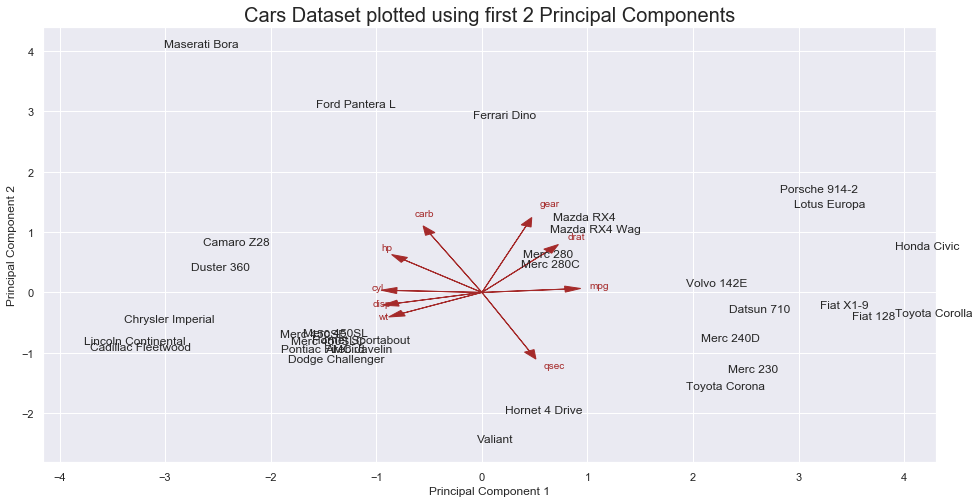

In [33]:
# to plot vectors from the center
# take the transverse of the matrix
vecs = pca.components_[0:2].T*2

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(quant_df_pca[:,0], quant_df_pca[:,1], 'o', markersize=0.01)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Cars Dataset plotted using first 2 Principal Components', fontsize=20)

# plotting arrowheads
for i, vec in enumerate(vecs):
    ax.arrow(0,0,vec[0],vec[1], color='brown', head_width=0.1)
    s = 1.3
    # s denotes the locational place
    ax.annotate(quant_df.columns[i], (s*vec[0], s*vec[1]), color='brown')

# annotating text
for i, txt in enumerate(cars_df_scaled['model']):
    #(x,y) for location
    ax.annotate(txt, (quant_df_pca[:,0][i], quant_df_pca[:,1][i]), size=12)

**Any patterns of interest?** Let us examine the geography more closely. Source: [this blog](https://www.datacamp.com/community/tutorials/pca-analysis-r). 

In [37]:
country = ["Japan", "US", "EU", "US", "EU", "Japan", "US", "EU", "US", "EU"]
times = [3, 4, 7, 3, 1, 3, 4, 3, 1, 3]
country_list = np.array(sum(([x]*y for x,y in zip(country, times)),[]))
country_list

array(['Japan', 'Japan', 'Japan', 'US', 'US', 'US', 'US', 'EU', 'EU',
       'EU', 'EU', 'EU', 'EU', 'EU', 'US', 'US', 'US', 'EU', 'Japan',
       'Japan', 'Japan', 'US', 'US', 'US', 'US', 'EU', 'EU', 'EU', 'US',
       'EU', 'EU', 'EU'], dtype='<U5')

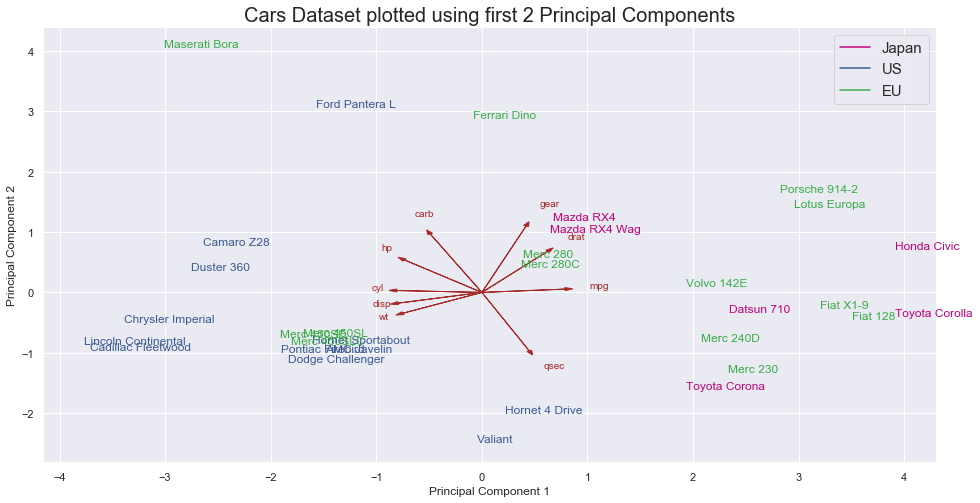

In [38]:
fig, ax = plt.subplots(figsize=(16,8))

# main plot
ax.plot(quant_df_pca[:,0], quant_df_pca[:,1], 'o', markersize=0.01)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Cars Dataset plotted using first 2 Principal Components', fontsize=20)

# plotting arrowheads
for i, vec in enumerate(vecs):
    ax.arrow(0,0,vec[0],vec[1], color='brown', head_width=0.05)
    s = 1.3
    ax.annotate(quant_df.columns[i], (s*vec[0], s*vec[1]), color='brown')

# plotting names
cs = [sns.xkcd_rgb["magenta"], sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["medium green"]]
colors = {"Japan": cs[0], "US": cs[1], "EU": cs[2]}

# dummy plots to show up in the legend
ax.plot(0,0, color=cs[0], label='Japan')
ax.plot(0,0, color=cs[1], label='US')
ax.plot(0,0, color=cs[2], label='EU')

# plotting text with color
for i, txt in enumerate(cars_df_scaled['model']):
    country = country_list[i]
    ax.annotate(txt, (quant_df_pca[:,0][i], quant_df_pca[:,1][i]), color=colors[country], size=12)
    
ax.legend(fontsize=15);

What patterns do you see now?

For instance, we can observe that fuel consumption (*mpg*) is increased for the japanese cars and weight (*wt*) is increased for US cars.

### Addressing `n_components`

We notice that PCA takes in 1 parameter: `n_components`. This is the number of principal components that PCA will  use. By default, the number of the used principal components is the minimum of the number of rows and the number of columns in the dataset. 

**Note**: Setting the default parameter for `n_components` and taking the top-k principal components is equivalent to setting `n_components=k`. Let's check this.

In [39]:
old_components = pca.components_[0:2]

# doing pca with 2 components
pca2 = PCA(n_components=2).fit(quant_df)

new_components = pca2.components_

# checking equivalence
print(new_components.all() == old_components.all())

True


# PCA to speed up classification of Handwritten Digits

This example, using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), was borrowed from this [Towards Data Science blog post](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60). In this example, we will be classifying hand-written digits.

## Data Loading and EDA

In [40]:
# we'll use keras a lot more in the last few weeks of the course
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


Our training set (`x_train`) contains 60000 images of size 28 by 28. Our training labels (`y_train`) are numbers from 0 to 9. Let's examine one of these values below.

5


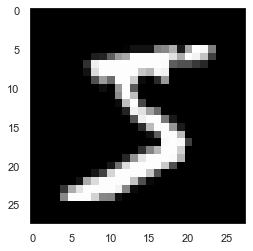

In [41]:
print(y_train[0])
fig, ax = plt.subplots()
ax.grid(None)
ax.imshow(x_train[0], cmap='gray');

**Our task** is to classify the test set digits as accurately as possible.

We notice that the shape of the training set is $6000 \times 28 \times 28$ which is a 3-dimensional array.  We have not dealt with these kinds of arrays before. We will deal with images in greater detail (and not only!!!) in the follow-up course, *CS 109b*, if you are interested in doing more of this kind of stuff you should take this course. For now, we will **reshape** the array into a 2-dimensional array of shape $6000\times 784$.

In [42]:
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# check if the shapes are ok
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


## Normalizing Data

Image data is usually between 0 and 255 (0 indicating a black pixel and 255 indicating a white pixel). We can normalize these values by dividing by 255. 

In [43]:
# checking the min and max of x_train and x_test
print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

x_train = (x_train - x_train.min())/(x_train.max() - x_train.min()) 
x_test = (x_test - x_train.min())/(x_train.max() - x_train.min()) 

print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

0 255 0 255
0.0 1.0 0.0 255.0


## Modeling using Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
from time import time

start = time()
#‘lbfgs’ solver handles multinomial loss in multiclass problems 
logreg_model = LogisticRegression(solver='lbfgs').fit(x_train, y_train)
end = time()


full_logreg_time = end-start
print('Time to fit: {}s'.format(full_logreg_time))

Time to fit: 61.45771098136902s


In [45]:
from sklearn.metrics import accuracy_score

y_preds_train = logreg_model.predict(x_train)
y_preds_test = logreg_model.predict(x_test)

full_logreg_score_train = accuracy_score(y_train, y_preds_train)
full_logreg_score_test = accuracy_score(y_test, y_preds_test)

# Evaluation
print('Training Set Score: {}'.format(full_logreg_score_train))
print('Test Set Score: {}'.format(full_logreg_score_test))

Training Set Score: 0.9278166666666666
Test Set Score: 0.8172


In [46]:
# get performance by class 
pd.crosstab(y_test, y_preds_test, margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,960,0,0,2,0,0,4,1,12,1,980
1,0,875,2,4,0,0,3,1,249,1,1135
2,8,2,808,27,3,0,15,3,161,5,1032
3,4,0,7,906,1,0,5,1,82,4,1010
4,4,0,5,4,773,0,14,1,114,67,982
5,20,1,0,89,6,314,22,4,419,17,892
6,10,1,4,1,2,2,903,0,35,0,958
7,7,1,15,15,4,0,1,809,61,115,1028
8,6,0,2,9,4,1,4,1,944,3,974


We get a high training and test set score but it takes a relatively long time to fit a model. Let us see if we can speed things up when using PCA

## Logistic Regression Model after PCA

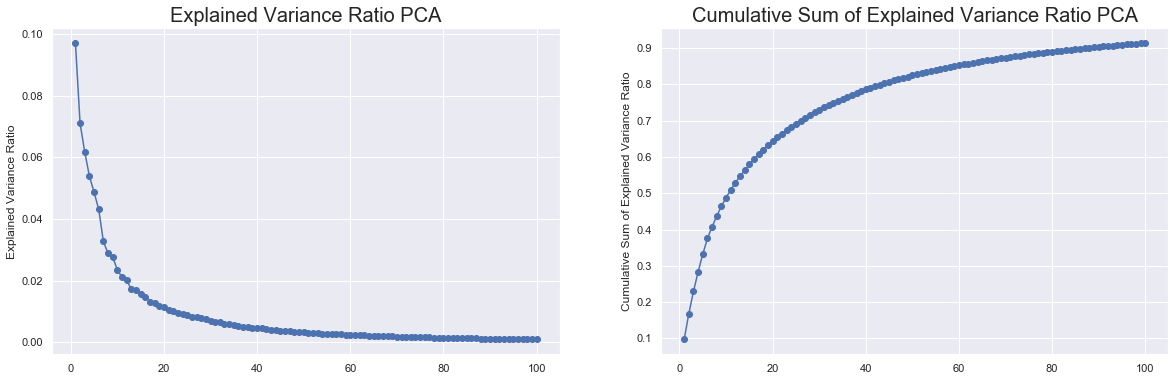

In [47]:
# Do PCA onto our training set and inspect
pca = PCA(n_components=100).fit(x_train)

fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.plot(range(1,len(ratio)+1), ratio, 'o-')
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_ylabel('Explained Variance Ratio')

ratio = pca.explained_variance_ratio_
ax2.plot(range(1,len(ratio)+1), np.cumsum(ratio), 'o-')
ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

We see that the first 100 principal components hold over 90% of the variance and the first 50 principal components hold over 80% of the variance! We have significantly reduced the dimensionality of our problem! Let us use PCA to find the first 100 principal components of our dataset and transform our `x_train` and `x_test` accordingly.

In [48]:
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

print(x_train_pca.shape, x_test_pca.shape)

(60000, 100) (10000, 100)


Time to fit model (100 PCs): 8.306012868881226s
Time to fit model (full dataset): 61.45771098136902s
So to fit the model with the full dataset is about 7.0  times slower than using PCA


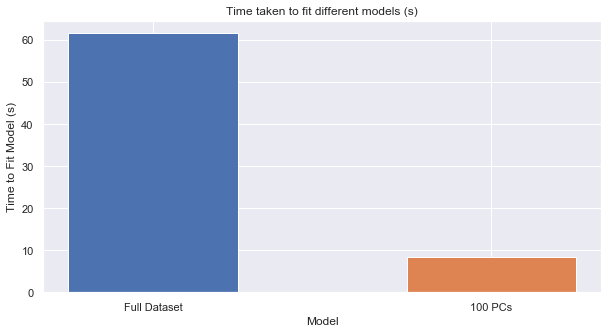

In [49]:
start = time()
logreg_model_pca = LogisticRegression(solver='lbfgs').fit(x_train_pca, y_train)
end = time()

print('Time to fit model (100 PCs): {}s'.format(end-start))
print('Time to fit model (full dataset): {}s'.format(full_logreg_time))
print('So to fit the model with the full dataset is about', np.round(full_logreg_time/(end-start),0), ' times slower than using PCA')

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(0, full_logreg_time, width=0.5)
ax.bar(1, end-start, width=0.5)
ax.set_xlabel('Model')
ax.set_xticks([0,1])
ax.set_xticklabels(['Full Dataset', '100 PCs'])
ax.set_ylabel('Time to Fit Model (s)')
ax.set_title('Time taken to fit different models (s)');

**Note:** The time taken to fit our model is considerably smaller! Now let us check our accuracy

In [50]:
y_preds_train_pca = logreg_model_pca.predict(x_train_pca)
y_preds_test_pca = logreg_model_pca.predict(x_test_pca)

# Evaluation
print('Training Set Score (100 PCs): {}'.format(accuracy_score(y_train, y_preds_train_pca)))
print('Test Set Score (100 PCs): {}\n'.format(accuracy_score(y_test, y_preds_test_pca)))

print('Training Set Score (full dataset): {}'.format(full_logreg_score_train))
print('Test Set Score (full dataset): {}'.format(full_logreg_score_test))

Training Set Score (100 PCs): 0.9120333333333334
Test Set Score (100 PCs): 0.8144

Training Set Score (full dataset): 0.9278166666666666
Test Set Score (full dataset): 0.8172


In [51]:
# get performance by class 
pd.crosstab(y_test, y_preds_test_pca, margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,966,0,0,0,0,0,4,1,9,0,980
1,0,912,1,7,0,0,3,0,212,0,1135
2,8,2,811,23,3,0,12,1,166,6,1032
3,7,0,11,890,1,0,5,1,91,4,1010
4,4,0,2,4,806,0,9,0,106,51,982
5,28,1,1,93,6,256,22,2,467,16,892
6,15,1,2,2,4,1,896,0,37,0,958
7,9,2,18,15,5,0,0,809,79,91,1028
8,6,0,0,7,4,0,3,1,952,1,974


Not a significant drop in accuracy!! But, since we are losing information by not accounting for all the variance, we are faced with a speed accuracy tradeoff. 
Explore the case of keeping less principal components.

## Plotting PCA

### Plotting the Reconstructed Image

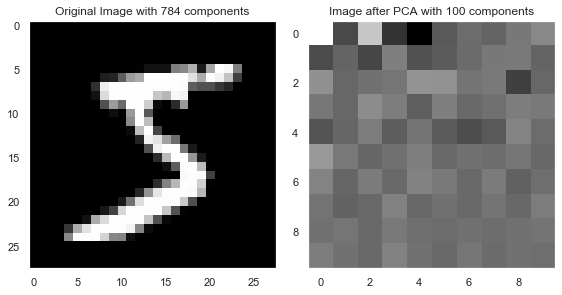

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1, ax2 = ax.ravel()

ax1.imshow(x_train[0].reshape(28,28), cmap='gray')
ax1.grid(None)
ax1.set_title('Original Image with 784 components')

ax2.imshow(x_train_pca[1].reshape(10,10), cmap='gray')
ax2.grid(None)
ax2.set_title('Image after PCA with 100 components')

fig.tight_layout()

Uhhh... this is terrible. But we can use PCA to carry out an inverse transform in order to get a reconstructed image. Let's try again, using `pca.inverse_transform()`! Source: [this github repo](https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Image_Reconstruction_and_such.ipynb) 

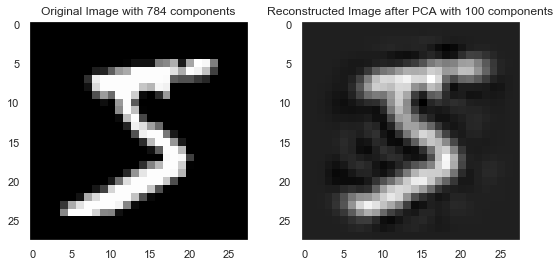

In [53]:
img_reconstructed = pca.inverse_transform(x_train_pca[0])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1, ax2 = ax.ravel()

ax1.imshow(x_train[0].reshape(28,28), cmap='gray')
ax1.grid(None)
ax1.set_title('Original Image with 784 components')

ax2.imshow(img_reconstructed.reshape(28,28), cmap='gray')
ax2.grid(None)
ax2.set_title('Reconstructed Image after PCA with 100 components')

fig.tight_layout()

### Plotting all our points on a 2-dimensional plot given by the first 2 principal components of PCA

This [towards data science article](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b) has a few similar plots that are pretty cool!

In [54]:
pca = PCA(n_components=2).fit(x_train)
x_train_2 = pca.transform(x_train)
print(x_train_2.shape)

(60000, 2)


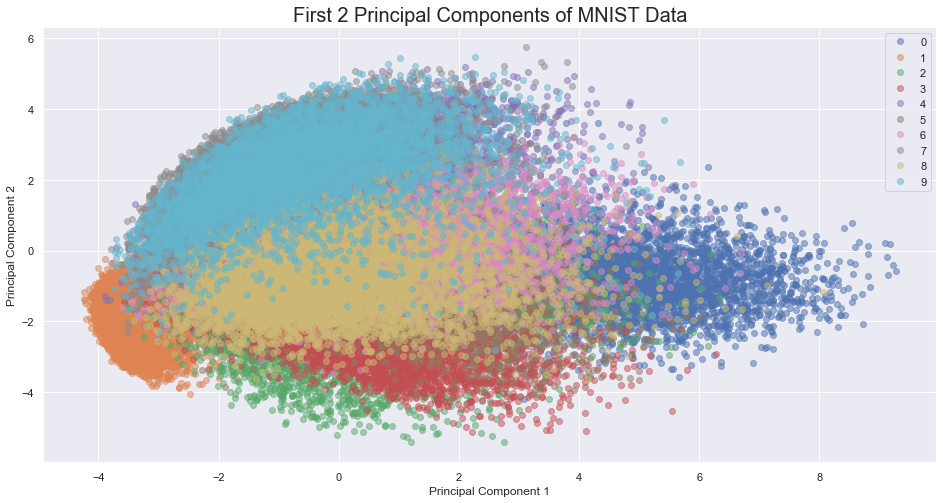

In [55]:
fig, ax = plt.subplots(figsize=(16,8))
for i in range(10):
    indices = np.where(y_train == i)[0]
    data = x_train_2[indices]
    ax.plot(data[:,0], data[:,1], 'o', label='{}'.format(i), alpha=0.5)
ax.set_title('First 2 Principal Components of MNIST Data', fontsize=20)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend();

Any patterns of interest?

# So, should I always use PCA?


PCA is **great** for:
1. Speeding up the training without significant descrease of the predictivity ability of a model compared to a model with all p predictors.
2. Visualizing how predictive your features can be of your response, especially in the case of classification.
3. Reducing multicollinearity, and thus may improve the computational time of fitting models.
4. Reducing dimensionality in very high dimensional settings.

PCA is **not so good** in certain situations because:
1. Interpretation of coefficients in PCR is completely lost. So do not do PCA if interpretation is important.
3. When the predictors' distribution deviates significantly from a multivariable Normal distribution.
4. When the high variance does not indicate high importance.
5. When the hidden dimensions are not orthonormal.


----------------
### End of Standard Section
---------------